In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Custom mGRU Cell

In [4]:
class mGRUCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        self.output_size = units
        super(mGRUCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_z = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z')
        self.W_h = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_h')
        self.b_h = self.add_weight(shape=(self.units,), initializer='zeros', name='b_h')
        self.built = True

    def call(self, inputs, states):
        h_prev = states[0]
        z = tf.sigmoid(tf.matmul(inputs, self.W_z) + self.b_z)
        h_tilde = tf.tanh(tf.matmul(inputs, self.W_h) + self.b_h)
        h = (1 - z) * h_prev + z * h_tilde
        return h, [h]

### Load and preprocess dataset

In [5]:
def load_and_preprocess_data(dataset_path):
    df = pd.read_csv(dataset_path)
    df = df.dropna()
    X = df.iloc[:, :-2].values
    y = df.iloc[:, -1].values
    le = LabelEncoder()
    y_multi = le.fit_transform(y)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_multi, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test, le.classes_

### Build mGRU model for multi-class classification

In [6]:
def build_mgru_model(num_features, num_classes):
    model = keras.Sequential([
        keras.layers.RNN(mGRUCell(128), return_sequences=True, input_shape=(1, num_features)),
        keras.layers.RNN(mGRUCell(64), return_sequences=True),
        keras.layers.RNN(mGRUCell(32), return_sequences=False),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Main execution

In [7]:
dataset_path = '/content/drive/MyDrive/multi-vector-IDS/code/CICIoT2023/CICIoT2023_selected_features_dataset.csv'

In [8]:
display(pd.read_csv(dataset_path).head())

,flow_duration,Header_Length,Protocol Type,Duration,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IPv,Tot sum,Min,Max,AVG,Tot size,IAT,Number,label,category
0,5.018181,125.82,6.00,64.00,0.471037,0.0,0.0,1.0,0.0,0.0,...,1.0,567.00,54.0,54.00,54.000000,54.00,8.336227e+07,9.5,DDoS-SynonymousIP_Flood,SynonymousIP_Flood
1,0.000000,0.00,47.00,64.00,4.992473,0.0,0.0,0.0,0.0,0.0,...,1.0,6216.00,592.0,592.00,592.000000,592.00,8.367746e+07,9.5,Mirai-greeth_flood,Mirai
2,0.000000,55.22,6.05,65.27,31.735421,0.0,0.0,0.0,0.0,0.0,...,1.0,570.58,54.0,57.52,54.183632,55.82,8.306829e+07,9.5,DDoS-TCP_Flood,TCP
3,0.008299,5213.00,17.00,64.00,19365.300906,0.0,0.0,0.0,0.0,0.0,...,1.0,525.00,50.0,50.00,50.000000,50.00,8.310303e+07,9.5,DDoS-UDP_Flood,UDP
4,4.672666,108.00,6.00,64.00,0.428021,0.0,0.0,0.0,0.0,0.0,...,1.0,567.00,54.0,54.00,54.000000,54.00,8.295115e+07,9.5,DoS-TCP_Flood,TCP


In [9]:
X_train, y_train, X_val, y_val, X_test, y_test, classes = load_and_preprocess_data(dataset_path)

### Prepare data with selected features

In [10]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Train mGRU model

In [11]:
model = build_mgru_model(X_train.shape[1], len(classes))
start_time = time.time()
history = model.fit(X_train_reshaped, y_train, epochs=40, batch_size=1000, validation_data=(X_test_reshaped, y_test))
training_time = time.time() - start_time

Epoch 1/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7467 - loss: 0.7959 - val_accuracy: 0.9401 - val_loss: 0.1637
Epoch 2/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9357 - loss: 0.1566 - val_accuracy: 0.9402 - val_loss: 0.1415
Epoch 3/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9426 - loss: 0.1417 - val_accuracy: 0.9449 - val_loss: 0.1369
Epoch 4/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9502 - loss: 0.1237 - val_accuracy: 0.9533 - val_loss: 0.1128
Epoch 5/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9556 - loss: 0.1111 - val_accuracy: 0.9541 - val_loss: 0.1095
Epoch 6/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9583 - loss: 0.1047 - val_accuracy: 0.9553 - val_loss: 0.1056
Epoch 7/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9589 - loss: 0.1024 - val_accuracy: 0.9614 - val_loss: 0.0994
Epoch 8/40
812/812 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9602 - loss: 0.1001 - 

### Evaluate

In [12]:
start_time = time.time()
y_pred = model.predict(X_test_reshaped)
detection_time = (time.time() - start_time) / len(y_test)
y_pred_class = np.argmax(y_pred, axis=1)

3261/3261 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


### Metrics

In [13]:
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred_class))

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

for i in range(len(classes)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (fp + fn + tp)

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    far = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"\nClass {classes[i]}:")
    print(f"  Sensitivity : {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  FAR: {far:.4f}")
    print(f"  FPR: {fpr:.4f}")


model.save('mce_model.h5')
model_size = os.path.getsize('mce_model.h5') / 1024  # KB
print(f"\nModel size: {model_size:.2f} KB")
print(f"Training time: {training_time:.2f} seconds")
print(f"Detection time per sample: {detection_time:.6f} seconds")

Confusion Matrix:
 [[  619     3     1     0     2     0     0     0     0     1     2]
 [    0  2489     0    64     0     0     0     0     1     1     0]
 [    3     0 17344     0     1     0     0     9     0     7    18]
 [    0   206     0   465     0     0     0     0     0     0     0]
 [    3     0     6     1  6033     0     0     8     1     0    11]
 [    0     0     1     0     1  9373     0     3     0     1     3]
 [    0     0     2     0     1     0  9156     3     0     2     1]
 [    0     1     9     0     2     4     0 13684   106     1    11]
 [    0     0     0     0     0     0     0  2380  5706     0     5]
 [    3     0     5     0     7     0     0     6     0 15979     4]
 [    1     1     9     0    12     0     0    10     0     1 20553]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       628
           1       0.92      0.97      0.95      2555
           2       1.00      1.00      1.00     17382
    

### Visualization

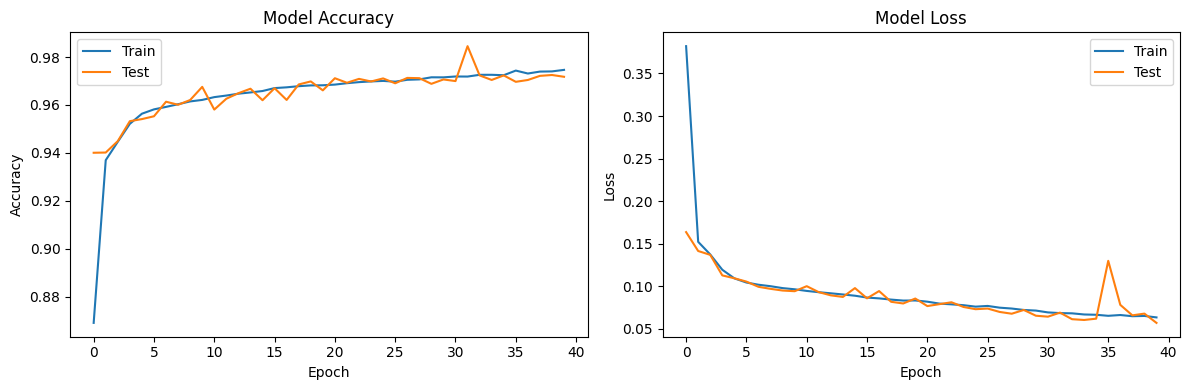

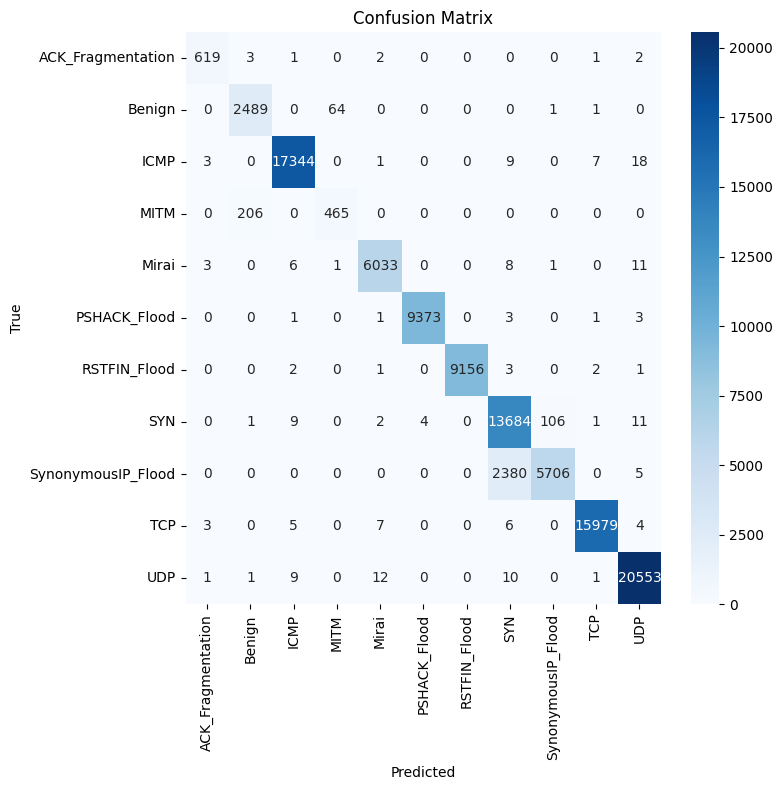

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\n")

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()